# Preparation

In [4]:
%matplotlib inline
import pandas as pd
import networkx as nx
# import netwulf as nw
import matplotlib.pyplot as plt
import seaborn as sns
import random

import numpy as np
# import matplotlib.lines as mlines

plt.rcParams['font.sans-serif'] = ['Times New Roman']  #防止中文乱码，还可以有Microsoft YaHei, Times New Roman, Arial
plt.rcParams["axes.unicode_minus"] = False   #字符显示，防止负号乱码

import warnings
warnings.filterwarnings('ignore')

In [5]:
from infomap import Infomap
from cdlib import algorithms, NodeClustering

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'bayanpy', 'wurlitzer', 'leidenalg'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg'}


In [6]:
geo = pd.read_csv("data/NYCTAXI202401-202403.geo")
geo.head()

,geo_id,type,coordinates
0,0,Polygon,"[[['-74.18445300', '40.69499600'], ['-74.18563..."
1,1,MultiPolygon,"[[[['-73.81768667', '40.61493300'], ['-73.8165..."
2,2,Polygon,"[[['-73.84240629', '40.86847474'], ['-73.84280..."
3,3,Polygon,"[[['-73.97464721', '40.71884235'], ['-73.97347..."
4,4,Polygon,"[[['-74.17225508', '40.56170484'], ['-74.17348..."


In [7]:
rel = pd.read_csv("data/NYCTAXI202401-202403.rel")
rel.head()

,rel_id,type,origin_id,destination_id,cost
0,0,geo,0,0,0.0
1,1,geo,0,1,31349.0
2,2,geo,0,2,33747.0
3,3,geo,0,3,17205.0
4,4,geo,0,4,14927.0


In [8]:
df_total = pd.read_csv("data/total/NYCTAXI_OD_Total.csv")

df_earlymorning = pd.read_csv("data/timeperiod/NYCTAXI_OD_Early Morning.csv")
df_morningrush = pd.read_csv("data/timeperiod/NYCTAXI_OD_Morning Rush.csv")
df_morningtonoon = pd.read_csv("data/timeperiod/NYCTAXI_OD_Morning to Noon.csv")
df_afternoon = pd.read_csv("data/timeperiod/NYCTAXI_OD_Afternoon.csv")
df_eveningrush = pd.read_csv("data/timeperiod/NYCTAXI_OD_Evening Rush.csv")
df_night = pd.read_csv("data/timeperiod/NYCTAXI_OD_Night.csv")

# df_total["flow"].value_counts()
# df_total["origin_id"].nunique()

In [9]:
df_total

,origin_id,destination_id,flow
0,0,47,0.000916
1,0,99,0.000458
2,0,186,0.000458
3,0,208,0.000458
4,0,230,0.000458
...,...,...,...
25966,262,257,0.002290
25967,262,258,0.004123
25968,262,259,0.017865
25969,262,260,0.069629


In [10]:
# df_afternoon.drop(columns=["Unnamed: 0"], inplace=True)
df_afternoon["flow"].value_counts()

flow
0.002747    4687
0.005495    1723
0.008242     856
0.010989     578
0.013736     378
            ... 
1.703297       1
3.159341       1
1.467033       1
6.030220       1
6.233516       1
Name: count, Length: 1059, dtype: int64

# Construct network

In [11]:
G_total = nx.DiGraph()

G_earlymorning = nx.DiGraph()
G_morningrush = nx.DiGraph()
G_morningtonoon = nx.DiGraph()
G_afternoon = nx.DiGraph()
G_eveningrush = nx.DiGraph()
G_night = nx.DiGraph()

In [12]:
def construct_graph(G, df):
    for i, row in df.iterrows():
        G.add_edge(row["origin_id"], row["destination_id"], flow=row["flow"])
    # G.add_nodes_from(rel["origin_id"].unique())
    
construct_graph(G_total, df_total)

construct_graph(G_earlymorning, df_earlymorning)
construct_graph(G_morningrush, df_morningrush)
construct_graph(G_morningtonoon, df_morningtonoon)
construct_graph(G_afternoon, df_afternoon)
construct_graph(G_eveningrush, df_eveningrush)
construct_graph(G_night, df_night)

In [13]:
def saveall_gexf():
    nx.write_gexf(G_total,"data/total/NYCTAXI_OD_Total.gexf")

    nx.write_gexf(G_earlymorning,"data/timeperiod/NYCTAXI_OD_Early Morning.gexf")
    nx.write_gexf(G_morningrush,"data/timeperiod/NYCTAXI_OD_Morning Rush.gexf")
    nx.write_gexf(G_morningtonoon,"data/timeperiod/NYCTAXI_OD_Morning to Noon.gexf")
    nx.write_gexf(G_afternoon,"data/timeperiod/NYCTAXI_OD_Afternoon.gexf")
    nx.write_gexf(G_eveningrush,"data/timeperiod/NYCTAXI_OD_Evening Rush.gexf")
    nx.write_gexf(G_night,"data/timeperiod/NYCTAXI_OD_Night.gexf")
# saveall_gexf()

In [14]:
# 服务器上不可用
# stylized_network, config = nw.visualize(G_afternoon, plot_in_cell_below=False)
# fig, ax = nw.draw_netwulf(stylized_network, figsize=(10,10))
# plt.savefig("myfigure.pdf")

In [15]:
# df_afternoon[df_afternoon["destination_id"] == 238]

In [16]:
# G_afternoon.edges(238,data=True)

# Basic statistics

## calculate

In [17]:
def get_network_statistics(G):
    # 基本统计量
    num_nodes = G.number_of_nodes()  # 节点数量
    num_edges = G.number_of_edges()  # 边数量

    # 平均度
    avg_degree = sum(dict(G.degree(weight = "flow")).values()) / num_nodes

    in_degrees = [deg for node, deg in G.in_degree(weight = "flow")]
    out_degrees = [deg for node, deg in G.out_degree(weight = "flow")]
    avg_in_degree = sum(in_degrees) / len(in_degrees)
    avg_out_degree = sum(out_degrees) / len(out_degrees)

    # Hubs（度数最高的节点）
    degree_dict = dict(G.degree(weight = "flow"))
    hubs = [node for node, degree in degree_dict.items() if degree == max(degree_dict.values())]
    in_degree_dict = dict(G.in_degree(weight = "flow"))
    in_hubs = [node for node, degree in in_degree_dict.items() if degree == max(in_degree_dict.values())]
    out_degree_dict = dict(G.out_degree(weight = "flow"))
    out_hubs = [node for node, degree in out_degree_dict.items() if degree == max(out_degree_dict.values())]

    # 最短路径长度
    shortest_path_lengths = dict(nx.shortest_path_length(G))

    # 直径（最长的最短路径长度）
    try:
        diameter = nx.diameter(G)
    except:
        diameter = "Network is not connected."

    # 最大连通分量
    largest_component = max(nx.strongly_connected_components(G), key=len)

    return {
        "Number of nodes": num_nodes,
        "Number of edges": num_edges,
        "Average degree": avg_degree,
        "Average inout-degree": avg_in_degree,
        # "Hubs": hubs,
        "In_hubs": in_hubs,
        "Out_hubs": out_hubs,
        # "Shortest path lengths": shortest_path_lengths,
        "Diameter": diameter,
        "Largest component": largest_component,
        "Size of largest component": len(largest_component)
    }

def print_statistics(G):
    # print("-"*45)
    stats = get_network_statistics(G)
    # for key, value in stats.items():
        # print(f"{key}: {value}")
    return stats

In [18]:
G_total_stats = print_statistics(G_total)

G_earlymorning_stats = print_statistics(G_earlymorning)
G_morningrush_stats = print_statistics(G_morningrush)
G_morningtonoon_stats = print_statistics(G_morningtonoon)
G_afternoon_stats = print_statistics(G_afternoon)
G_eveningrush_stats = print_statistics(G_eveningrush)
G_night_stats = print_statistics(G_night)

In [19]:
df_statistics = pd.DataFrame(
    [G_total_stats, G_earlymorning_stats, G_morningrush_stats, G_morningtonoon_stats, G_afternoon_stats, G_eveningrush_stats, G_night_stats],
    index=["Total", "Early Morning", "Morning Rush", "Morning to Noon", "Afternoon", "Evening Rush", "Night"]
)
df_statistics

,Number of nodes,Number of edges,Average degree,Average inout-degree,In_hubs,Out_hubs,Diameter,Largest component,Size of largest component
Total,260,25971,23.366514,11.683257,[235.0],[160.0],Network is not connected.,"{0.0, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",255
Early Morning,258,15154,8.081243,4.040622,[78.0],[78.0],Network is not connected.,"{0.0, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",246
Morning Rush,255,14070,21.578302,10.789151,[160.0],[235.0],Network is not connected.,"{0.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...",239
Morning to Noon,252,11080,28.594104,14.297052,[236.0],[235.0],Network is not connected.,"{2.0, 3.0, 5.0, 6.0, 8.0, 9.0, 10.0, 11.0, 12....",234
Afternoon,255,13389,31.936738,15.968369,[235.0],[236.0],Network is not connected.,"{0.0, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",246
Evening Rush,252,12076,39.766818,19.883409,[235.0],[160.0],Network is not connected.,"{0.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...",242
Night,258,14630,31.175839,15.587919,[235.0],[160.0],Network is not connected.,"{1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...",247


## plot

findfont: Generic family 'sans-serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'sans-serif' not found because none of the following fa

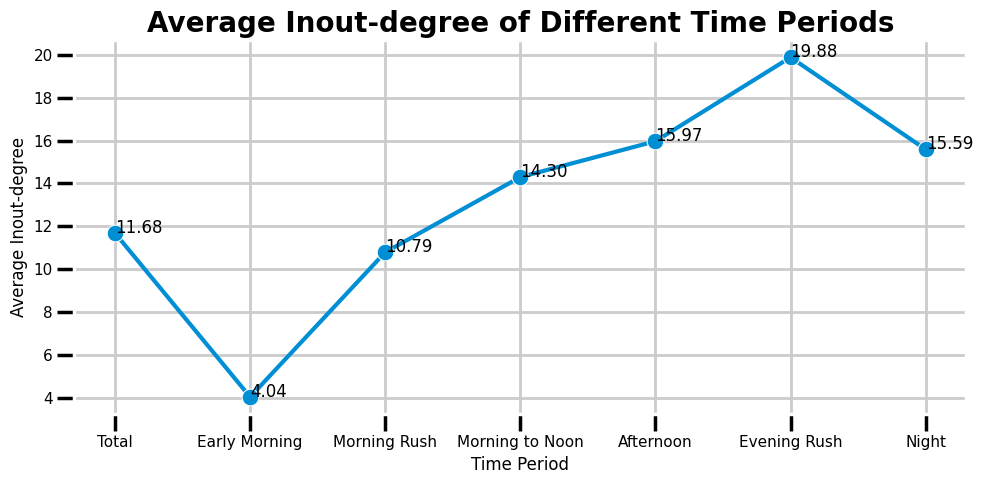

In [20]:
with plt.style.context("fivethirtyeight"), sns.plotting_context(context="poster",font_scale=0.5):
    fig,ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('white')  # 设置整个图的背景颜色为白色
    line = sns.lineplot(x=df_statistics.index, y="Average inout-degree", data=df_statistics,marker = "o")
    
    ax.set_facecolor('white')    # 设置轴的边框颜色为白色
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        
    for x, y in zip(df_statistics.index, df_statistics["Average inout-degree"]):
        ax.text(x, y, f'{y:.2f}', color='black', ha='left')
    plt.xlabel("Time Period")
    plt.ylabel("Average Inout-degree")
    plt.title("Average Inout-degree of Different Time Periods",fontsize = 20,weight = "bold")
    plt.tight_layout()
    # plt.savefig("output/plot/Average Inout-degree of Different Time Periods.svg", bbox_inches="tight", transparent=True)
    # plt.savefig("output/plot/Average Inout-degree of Different Time Periods.pdf", bbox_inches="tight", transparent=True)

In [21]:

networks = [G_earlymorning, G_morningrush, G_morningtonoon, G_afternoon, G_eveningrush, G_night,G_total]  # replace with your actual networks
titles = ["Early Morning", "Morning Rush", "Morning to Noon", "Afternoon", "Evening Rush", "Night","Total"]  # replace with your actual titles

def plot_degree(i,ax):
    G = networks[i]
    in_degree_sequence = [G.in_degree(node,weight = "flow") for node in G if G.in_degree(node,weight = "flow") > 0]
    out_degree_sequence = [G.out_degree(node,weight = "flow") for node in G if G.out_degree(node,weight = "flow") > 0]

    kmin_in = min(in_degree_sequence)
    kmax_in = max(in_degree_sequence)
    bin_edges_in = np.logspace(np.log10(kmin_in), np.log10(kmax_in), num=10)
    density_in, _ = np.histogram(in_degree_sequence, bins=bin_edges_in, density=True)

    kmin_out = min(out_degree_sequence)
    kmax_out = max(out_degree_sequence)
    bin_edges_out = np.logspace(np.log10(kmin_out), np.log10(kmax_out), num=10)
    density_out, _ = np.histogram(out_degree_sequence, bins=bin_edges_out, density=True)

    log_be_in = np.log10(bin_edges_in)
    x_in = 10**((log_be_in[1:] + log_be_in[:-1])/2)
    log_be_out = np.log10(bin_edges_out)
    x_out = 10**((log_be_out[1:] + log_be_out[:-1])/2)

    line1 = sns.lineplot(x=x_in, y=density_in, marker='o', label='In-degree', ax=ax,markersize = 7)
    line2 = sns.lineplot(x=x_out, y=density_out, marker='o', label='Out-degree', ax=ax,markersize = 7)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r"degree $k$", fontsize=16)
    ax.set_ylabel(r"$P(k)$", fontsize=16)
    ax.set_title(titles[i])
    # ax.legend()
    return line1, line2

In [22]:
with plt.style.context("fivethirtyeight"), sns.plotting_context(context="poster",font_scale=0.5):
    fig, axs = plt.subplots(2, 3, figsize=(14,10))
    plt.suptitle("Degree Distribution of Different Time Periods", fontsize=30, weight="bold")
    plt.subplots_adjust(top = 0.9)
    fig.patch.set_facecolor('white')
    for i, ax in enumerate(axs.flatten()):
        ax.grid(False)
        (line1, line2) = plot_degree(i, ax)
        ax.set_facecolor('white')
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
        # ax.legend().set_visible(False)
    
    plt.tight_layout()
plt.savefig("output/plot/Degree distribution of different time periods.svg",bbox_inches="tight",transparent=True)
plt.savefig("output/plot/Degree distribution of different time periods.pdf",bbox_inches="tight",transparent=True)

假设是直线，他们的幂指数为-1，不合理

The change in slope (steepness) suggests a difference in the way in-degrees and out-degrees are distributed across the network during different times. 

There is a noticeable point around the degree range of 0.1 to 1 where the in-degree and out-degree distributions intersect. Below this point, the in-degree is generally higher than the out-degree, while above this point, the out-degree is higher than the in-degree. This transition point can be indicative of different underlying processes governing the degree distributions at lower and higher degrees.

There are more nodes have small out degree, while more nodes have large in degree. 出去的话就是单个单个，但是进去的就是成群结队的多。转折点再degree 等于0.1-1之间。

# Null model

## configuration model

In [23]:

# def configuration_model_directed(G):
#     in_degrees = [G.in_degree(n) for n in G.nodes()]
#     out_degrees = [G.out_degree(n) for n in G.nodes()]

#     null_model = nx.directed_configuration_model(in_degrees, out_degrees)
#     null_model = nx.DiGraph(null_model)    # 将生成的多重边图转换为简单图

#     # 随机分配边的权重
#     original_weights = [data['flow'] for _, _, data in G.edges(data=True)]
#     for (u, v, data) in null_model.edges(data=True):
#         data['flow'] = random.choice(original_weights)

#     return null_model

# config_model = configuration_model_directed(G_total)

# # print("Edges and weights in the null model:")
# # for (u, v, data) in config_model.edges(data=True):
# #     print(f"({u}, {v}, {data['flow']})")


## Degree-Preserving Randomization

In [24]:
import copy

def degree_preserving_randomization(G, iterations=1000):
    # Copy the original graph to keep degree distribution intact
    null_model = copy.deepcopy(G)
    
    edges = list(null_model.edges(data=True))
    num_edges = len(edges)
    
    for _ in range(iterations):
        # Randomly select two edges
        i, j = random.sample(range(num_edges), 2)
        (u1, v1, data1) = edges[i]
        (u2, v2, data2) = edges[j]
        
        # Swap endpoints to preserve degree distribution
        if u1 != u2 and v1 != v2 and not null_model.has_edge(u1, v2) and not null_model.has_edge(u2, v1):
            null_model.remove_edge(u1, v1)
            null_model.remove_edge(u2, v2)
            null_model.add_edge(u1, v2, flow=data1['flow'])
            null_model.add_edge(u2, v1, flow=data2['flow'])
            
            # Update edge list
            edges[i] = (u1, v2, data1)
            edges[j] = (u2, v1, data2)

    # Shuffle the weights randomly
    weights = [data['flow'] for _, _, data in null_model.edges(data=True)]
    random.shuffle(weights)
    
    for (u, v, data), weight in zip(null_model.edges(data=True), weights):
        data['flow'] = weight

    return null_model


random_swap_model = degree_preserving_randomization(G_total, iterations=1000)

# print("Edges and weights in the null model:")
# for (u, v, data) in random_swap_model.edges(data=True):
#     print(f"({u}, {v}, {data['flow']})")


# Structure

## Clustering coefficient

在有向图中，节点i的聚类系数定义为所有可能的有向三元组（即i -> j, j -> k, k -> i）的比例，其中j和k是i的邻居。一个有向三元组是一个节点对的有序三元组。nx.average_clustering()函数默认会将有向图视为无向图进行计算。

In [25]:
# avg_clustering = nx.average_clustering(G, count_zeros=False)
G_total_avcl = nx.average_clustering(G_total,weight="flow")
# config_avcl = nx.average_clustering(config_model,weight="flow")
random_swap_avcl = nx.average_clustering(random_swap_model,weight="flow")

G_total_cl = nx.clustering(G_total,weight="flow")
# config_cl = nx.clustering(config_model,weight="flow")
random_swap_cl = nx.clustering(random_swap_model,weight="flow")

In [26]:
# 提取聚类系数和度数
G_total_degrees = [deg for node, deg in G_total.in_degree(weight="flow")]
G_total_cl_values = list(G_total_cl.values())

# config_degrees = [deg for node, deg in config_model.in_degree(weight="flow")]
# config_cl_values = list(config_cl.values())

random_swap_degrees = [deg for node, deg in random_swap_model.in_degree(weight="flow")]
random_swap_cl_values = list(random_swap_cl.values())

In [27]:
# plt.style.available

In [28]:
with plt.style.context("fivethirtyeight"), sns.plotting_context(context="poster",font_scale=0.5):
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

    plt.scatter(G_total_degrees, G_total_cl_values, alpha=0.5, label='G_total')
    # plt.scatter(config_degrees, config_cl_values, alpha=0.5, label='config_model')
    plt.scatter(random_swap_degrees, random_swap_cl_values, alpha=0.5, label='random_swap_model')

    plt.xlabel('Degree ($k$)')
    plt.ylabel('Clustering Coefficient $C(k)$')
    plt.title('Scatter plot of Clustering Coefficient vs Degree',fontsize = 20,weight = "bold")
    plt.tight_layout()
    plt.grid(False)
    # plt.legend([f"Original network ($<C>$ = {G_total_avcl:2f})", f"Configuration model ($<C>$ = {config_avcl:2f})",f"Degree preserve random ($<C>$ = {config_avcl:2f})"],loc = "lower right",frameon = True)
    plt.legend([f"Original network ($<C>$ = {G_total_avcl:2f})",f"Degree preserve random ($<C>$ = {random_swap_avcl:2f})"],loc = "lower right",frameon = True)
    # plt.show()
    plt.tight_layout()
    plt.savefig("output/plot/Clustering Coefficient vs Degree.svg",bbox_inches="tight",transparent=True)
    plt.savefig("output/plot/Clustering Coefficient vs Degree.pdf",bbox_inches="tight",transparent=True)


For 6 networks

In [29]:
G_total_avcl = nx.average_clustering(G_total,weight="flow")
G_earlymorning_avcl = nx.average_clustering(G_earlymorning,weight="flow")
G_morningrush_avcl = nx.average_clustering(G_morningrush,weight="flow")
G_morningtonoon_avcl = nx.average_clustering(G_morningtonoon,weight="flow")
G_afternoon_avcl = nx.average_clustering(G_afternoon,weight="flow")
G_eveningrush_avcl = nx.average_clustering(G_eveningrush,weight="flow")
G_night_avcl = nx.average_clustering(G_night,weight="flow")


In [30]:
print(
    f"Average clustering coefficient of the total network: {G_total_avcl}\n"
    f"Average clustering coefficient of the early morning network: {G_earlymorning_avcl}\n"
    f"Average clustering coefficient of the morning rush network: {G_morningrush_avcl}\n"
    f"Average clustering coefficient of the morning to noon network: {G_morningtonoon_avcl}\n"
    f"Average clustering coefficient of the afternoon network: {G_afternoon_avcl}\n"
    f"Average clustering coefficient of the evening rush network: {G_eveningrush_avcl}\n"
    f"Average clustering coefficient of the night network: {G_night_avcl}"
)

Average clustering coefficient of the total network: 0.0008061805452651452

Average clustering coefficient of the early morning network: 0.002619084466701479

Average clustering coefficient of the morning rush network: 0.0012166901246307984

Average clustering coefficient of the morning to noon network: 0.001313408868252395

Average clustering coefficient of the afternoon network: 0.0011170801184162173

Average clustering coefficient of the evening rush network: 0.0017199164843084062

Average clustering coefficient of the night network: 0.002182097694896068

## Betweeen centrality

In [31]:
# G_total_bc = nx.betweenness_centrality(G_total,weight="flow")
# config_bc = nx.betweenness_centrality(config_model,weight="flow")
# random_swap_bc = nx.betweenness_centrality(random_swap_model,weight="flow")

# G_earlymorning_bc = nx.betweenness_centrality(G_total,weight="flow")
# G_morningrush_bc = nx.betweenness_centrality(G_morningrush_bc,weight="flow")
# G_morningtonoon_bc = nx.betweenness_centrality(G_morningtonoon_bc,weight="flow")
# G_afternoon_bc = nx.betweenness_centrality(G_afternoon_bc,weight="flow")
# G_eveningrush_bc = nx.betweenness_centrality(G_eveningrush_bc,weight="flow")
# G_night_bc = nx.betweenness_centrality(G_night_bc,weight="flow")



In [32]:
# G_total_bc_values = list(G_total_bc.values())
# config_bc_values = list(config_bc.values())
# random_swap_bc_values = list(random_swap_bc.values())


In [33]:
# nx.draw(G_total, node_size=[v * 1000 for v in G_total_bc_values])

# Community

In [34]:
def community_detection_with_algorithms(G):
    partition_louvain = nx.community.louvain_communities(G, seed=123)
    modularity_louvain = nx.community.quality.modularity(G, partition_louvain,weight = "flow")
    # print(f"Louvain Modularity: {modularity_louvain}")

    # Infomap
    infomap = Infomap(directed=True,num_trials= 15)
    # communities_infomap = 
    for e in G.edges(data=True):
        infomap.addLink(e[0], e[1], e[2]['flow'])
    infomap.run()

    # 去重处理
    communities_infomap = {}
    for node in infomap.iterTree():
        if node.isLeaf():
            module_id = node.module_id
            if module_id not in communities_infomap:
                communities_infomap[module_id] = []
            communities_infomap[module_id].append(node.node_id)
    partition_infomap = list(communities_infomap.values())
        
    # Calculate modularity for Infomap
    modularity_infomap = nx.community.quality.modularity(G, partition_infomap, weight='weight')
    # print(f"Infomap Modularity: {modularity_infomap}")

    return {
        'Louvain': partition_louvain,
        "Louvain_modularity":modularity_louvain,
        'Infomap': partition_infomap,
        "Infor_modularity":modularity_infomap
    }
    
def save_partiton_tograph(G, partition, partition_name):
    # Add community to node attributes
    for i, comm in enumerate(partition):
        for node in comm:
            G.nodes[node][partition_name] = i

In [35]:
def get_community_result(G):
    community_dict = community_detection_with_algorithms(G)
    # print(f"Number of communities detected by Louvain: {len(community_counts['Louvain'])}")
    # print(f"Number of communities detected by Infomap: {len(community_counts['Infomap'])}")
    save_partiton_tograph(G,community_dict["Louvain"],"Louvain_community")
    save_partiton_tograph(G,community_dict["Infomap"],"Infomap_community")
    return len(community_dict['Louvain']), len(community_dict['Infomap']), community_dict['Louvain_modularity'],community_dict["Infor_modularity"]

In [36]:
total_Lpartition_len, total_Ipartition_len, total_Lpartition_m, total_Ipartition_m = get_community_result(G_total)
earlymorning_Lpartition_len, earlymorning_Ipartition_len, earlymorning_Lpartition_m, earlymorning_Ipartition_m = get_community_result(G_earlymorning)
morningrush_Lpartition_len, morningrush_Ipartition_len, morningrush_Lpartition_m, morningrush_Ipartition_m = get_community_result(G_morningrush)
morningtonoon_Lpartition_len, morningtonoon_Ipartition_len, morningtonoon_Lpartition_m, morningtonoon_Ipartition_m = get_community_result(G_morningtonoon)
afternoon_Lpartition_len, afternoon_Ipartition_len, afternoon_Lpartition_m, afternoon_Ipartition_m = get_community_result(G_afternoon)
eveningrush_Lpartition_len, eveningrush_Ipartition_len, eveningrush_Lpartition_m, eveningrush_Ipartition_m = get_community_result(G_eveningrush)
night_Lpartition_len, night_Ipartition_len, night_Lpartition_m, night_Ipartition_m = get_community_result(G_night)

  Infomap v2.7.1 starts at 2024-05-31 18:06:47
  -> Input network: 
  -> No file output!
  -> Configuration: directed
                    num-trials = 15
  OpenMP 201511 detected with 16 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'directed'... 
  -> Using unrecorded teleportation to links. 
  -> PageRank calculation done in 200 iterations.

  => Sum node flow: 1, sum link flow: 1
Build internal network with 260 nodes and 25971 links...
  -> One-level codelength: 6.09487535

Trial 1/15 starting at 2024-05-31 18:06:47
Two-level compression: 1.6% 0.018% 
Partitioned to codelength 0.111400531 + 5.88697771 = 5.998378245 in 6 modules.
Super-level compression: to codelength 5.998378245 in 6 top modules.

Recursive sub-structure compression: 0% . Found 2 levels with codelength 5.998378245

=> Trial 1/15 finished in 0.024082904s with codelength 5.99837824

Trial 2/15 starting at 2024-05-31 18:06:4

In [37]:
df_community = pd.DataFrame(
    {
        "Total": [total_Lpartition_len, total_Ipartition_len, total_Lpartition_m, total_Ipartition_m],
        "Early Morning": [earlymorning_Lpartition_len, earlymorning_Ipartition_len, earlymorning_Lpartition_m, earlymorning_Ipartition_m],
        "Morning Rush": [morningrush_Lpartition_len, morningrush_Ipartition_len, morningrush_Lpartition_m, morningrush_Ipartition_m],
        "Morning to Noon": [morningtonoon_Lpartition_len, morningtonoon_Ipartition_len, morningtonoon_Lpartition_m, morningtonoon_Ipartition_m],
        "Afternoon": [afternoon_Lpartition_len, afternoon_Ipartition_len, afternoon_Lpartition_m, afternoon_Ipartition_m],
        "Evening Rush": [eveningrush_Lpartition_len, eveningrush_Ipartition_len, eveningrush_Lpartition_m, eveningrush_Ipartition_m],
        "Night": [night_Lpartition_len, night_Ipartition_len, night_Lpartition_m, night_Ipartition_m]
    },
    index=["Louvain Community Count", "Infomap Community Count", "Louvain Modularity", "Infomap Modularity"]
)
df_community.to_csv("data/df_community.csv",index = True)

In [38]:
saveall_gexf()

### save total partition to geo

In [44]:
tmp = community_detection_with_algorithms(G_total)
# tmp

  Infomap v2.7.1 starts at 2024-05-31 18:09:57
  -> Input network: 
  -> No file output!
  -> Configuration: directed
                    num-trials = 15
  OpenMP 201511 detected with 16 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'directed'... 
  -> Using unrecorded teleportation to links. 
  -> PageRank calculation done in 200 iterations.

  => Sum node flow: 1.000000000, sum link flow: 1.000000000
Build internal network with 260 nodes and 25971 links...
  -> One-level codelength: 6.094875347

Trial 1/15 starting at 2024-05-31 18:09:57
Two-level compression: 1.57% 0.02% 
Partitioned to codelength 0.111400531 + 5.886977713 = 5.998378245 in 6 modules.
Super-level compression: to codelength 5.998378245 in 6 top modules.

Recursive sub-structure compression: 0.000000000% . Found 2 levels with codelength 5.998378245

=> Trial 1/15 finished in 0.025898299s with codelength 5.998378245

Trial 2/

In [52]:
def save_partition_togeo(partition, filename):
    for i, comm in enumerate(partition):
        for node in comm:
            geo.loc[geo["geo_id"]==node,"community"] = str(i)
    geo[["geo_id","community"]].to_csv(f"data/geo_community/geo_community_{filename}.csv" ,index=False)

In [53]:
save_partition_togeo(tmp["Louvain"],"Louvain")
save_partition_togeo(tmp["Infomap"],"Infomap")

In [41]:
# geo["community"].value_counts()